In [52]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

## Feature Selection Demonstration: Permutation Importance

In our dataset with over 2000 features, we use a visualization step before applying permutation importance. This involves:

1. **Selecting a Random Subset**: We start by sampling 50 features to manage complexity for demonstration purposes. In the actual code we start with all features.
2. **Hierarchical Clustering Dendrogram**: Visualizes feature similarity, helping to identify clusters of related features.
3. **Correlation Matrix Heatmap**: Highlights the linear relationships between features, identifying redundancy.

These visualizations are useful for understanding how the iterative refining process works.

Note: This implementation is based on the sklearn documentation. However, ours is modified to iteratively reduce features at or below the 0 score

In [53]:
import ast # used for parsing string to list
import os

import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.base import clone

from utils.constants import SEED
from select_models import baseline_models, model_needs_scaling, timing_decorator


In [62]:
def load_data(target_type='bear', split_type='std', subset=None, seed=SEED):
    base_path = "split_data/"
    X_train_file = f"X_train_{target_type}_{split_type}.csv"
    y_train_file = f"y_train_{target_type}_{split_type}.csv"
    X_test_file = f"X_test_{target_type}_{split_type}.csv"
    y_test_file = f"y_test_{target_type}_{split_type}.csv"
    
    X_train = pd.read_csv(base_path + X_train_file)
    y_train = pd.read_csv(base_path + y_train_file)
    X_test = pd.read_csv(base_path + X_test_file)
    y_test = pd.read_csv(base_path + y_test_file)
    
    # Drop the USREC column from X_train and X_test
    X_train = X_train.drop(columns=["USREC"]) # Maybe do this in the split_data script?
    X_test = X_test.drop(columns=["USREC"])

    if subset:
        # Sample columns
        print(f"Subsetting data to {subset} random columns.")
        sampled_columns = X_train.sample(n=subset, axis=1, random_state=seed).columns
        
        X_train = X_train[sampled_columns]
        X_test = X_test[sampled_columns]

    print(f"Loaded {X_train_file}, {y_train_file}, {X_test_file}, and {y_test_file}.\n")
    return X_train, y_train.values.ravel(), X_test, y_test.values.ravel()


def train_classifier(model, X_train, y_train):
    clf = model
    clf.fit(X_train, y_train)
    return clf

def create_correlation_matrix(X):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2  # Ensure the correlation matrix is symmetric
    np.fill_diagonal(corr, 1)
    return corr

def perform_hierarchical_clustering(corr):
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    return dist_linkage

def plot_dendrogram(X, ax):
    corr = create_correlation_matrix(X)
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax, leaf_rotation=90)
    return dendro

def plot_heatmap(corr, dendro, ax):
    ax.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax.set_xticks(np.arange(0, len(dendro["ivl"])))
    ax.set_yticks(np.arange(0, len(dendro["ivl"])))
    ax.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro["ivl"])

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax    

In [63]:
n = 50 # Number of columns to sample

X_train, y_train, X_test, y_test = load_data(subset=n)
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)

clf = train_classifier(RandomForestClassifier(random_state=SEED), X_train, y_train)
print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")


Subsetting data to 50 random columns.
Loaded X_train_bear_std.csv, y_train_bear_std.csv, X_test_bear_std.csv, and y_test_bear_std.csv.

Baseline accuracy on test data: 0.91


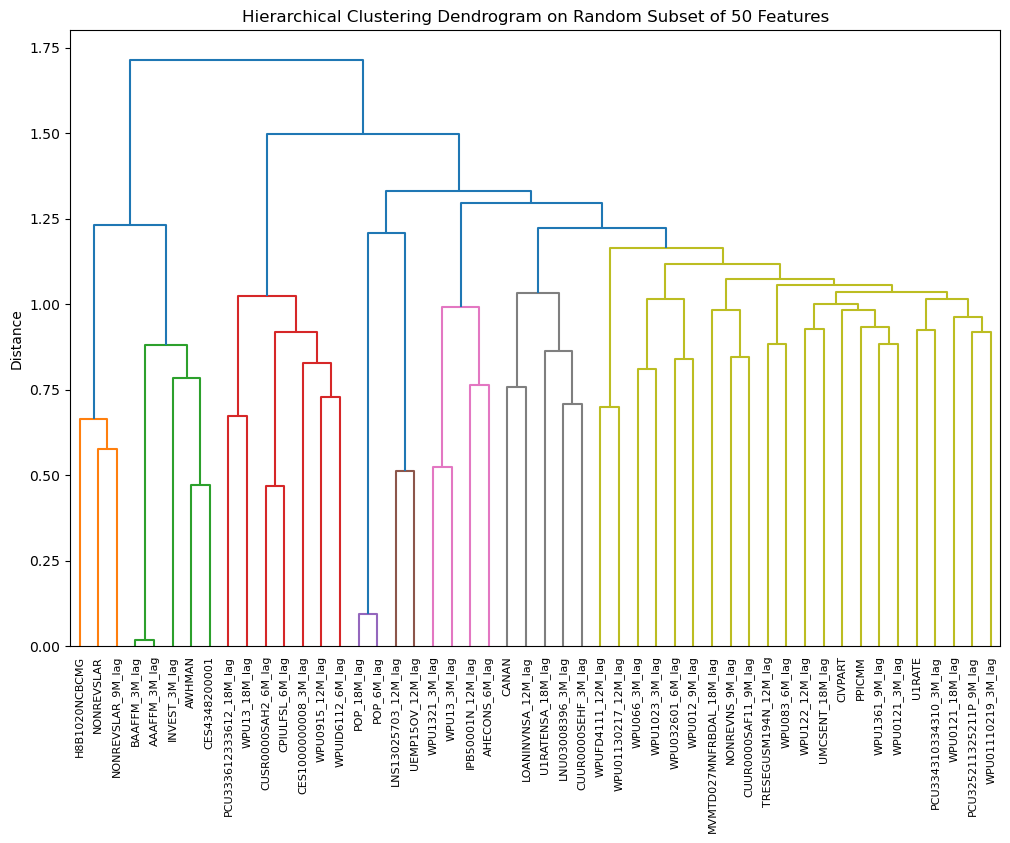

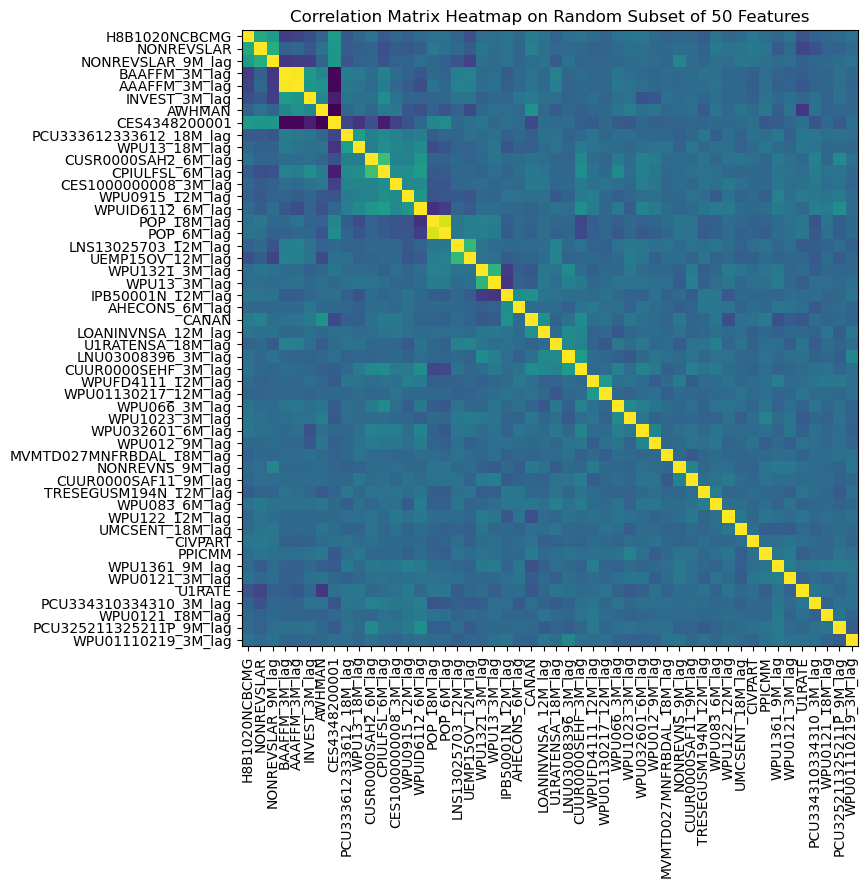

In [64]:
# Plot Dendrogram
fig1, ax1 = plt.subplots(figsize=(12, 8))
dendro = plot_dendrogram(X, ax1)
plt.title(f'Hierarchical Clustering Dendrogram on Random Subset of {n} Features')
ax1.set_ylabel('Distance')
plt.show()

# Plot Heatmap
fig2, ax2 = plt.subplots(figsize=(12, 8))
corr = create_correlation_matrix(X)
plot_heatmap(corr, dendro, ax2)
plt.title(f'Correlation Matrix Heatmap on Random Subset of {n} Features')
plt.show()

## Iterative Feature Refinement Process

This code snippet demonstrates our iterative process for refining feature selection through hierarchical clustering and permutation importance. 

1. **Hierarchical Clustering**: We cluster features based on their correlation, reducing redundancy by selecting only one feature per cluster.
2. **Permutation Importance**: We assess the remaining features' impact on model accuracy, visualizing this through permutation importance plots.

Features at or below a 0 score line are iteratively removed, as they do not contribute to, or may even reduce model accuracy. This reduction ensures our model relies only on features that enhance predictive performance. 

(Note: Although the demo on the sklearn documentation shows an increase in scores after feature reduction, the scores in this demonstration are *decreased* because we are random sampling a much smaller subset so that the prior dendrogram and correlation matrix visualizations are not too overcrowded.)

In [65]:
dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X)) # Recreate the distance matrix

def select_features_by_cluster(X, dist_linkage, threshold=1):
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return X.columns[selected_features]

selected_features_names = select_features_by_cluster(X, dist_linkage, 1)

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]
clf_sel = train_classifier(RandomForestClassifier(random_state=SEED), X_train_sel, y_train)

print(
    "Baseline accuracy on test data with features removed:" # See note in the markdown comments above
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.68


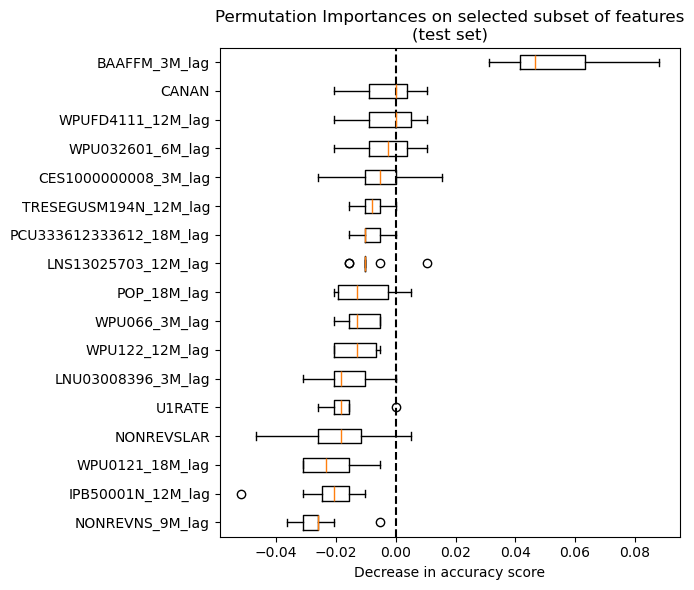

In [66]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

## First Iteration
Iteratively remove features scoring at or below 0. Feature significance varies by dataset, target, and classifier type. A feature's score may change with iterations as feature combinations impact model performance differently.

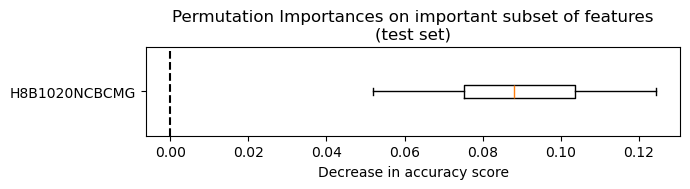

Baseline accuracy on test data with features removed: 0.67


In [67]:
def filter_features_by_importance(X, perm_importance, threshold=0.005):
    important_feature_indices = np.where(perm_importance.importances_mean >= threshold)[0]
    important_features = X.columns[important_feature_indices]
    return important_features

result = permutation_importance(clf_sel, X_test_sel, y_test, n_repeats=10, random_state=42, n_jobs=-1)

X_train_important = X_train[filter_features_by_importance(X_train, result, threshold=0.005)]
X_test_important = X_test[filter_features_by_importance(X_train, result, threshold=0.005)]
clf_important = train_classifier(RandomForestClassifier(random_state=SEED), X_train_important, y_train)

# plot
fig, ax = plt.subplots(figsize=(7, 2))
plot_permutation_importance(clf_important, X_test_important, y_test, ax)
ax.set_title("Permutation Importances on important subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_important.score(X_test_important, y_test):.2}"
)

In [90]:
def export_results(best_scores, best_features, filename='feature_selection_results.csv'):
    base_path = "feature_selection/"
    results_df = pd.DataFrame(best_scores.items(), columns=['model', 'best_score'])
    results_df['best_features'] = best_features.values()

    results_df = results_df.dropna()

    # tab separated file
    results_df.to_csv(base_path + filename, index=False, sep='\t')
    print(f"Results exported to {filename}")

    # Parse the 'best_features' column from string representation of a list to an actual list
    # results_df['best_features'] = results_df['best_features'].apply(ast.literal_eval)
    return results_df

def calculate_permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1):
    result = permutation_importance(clf, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs)
    return result

def get_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions, average='macro', zero_division=0),
        'recall': recall_score(y_test, predictions, average='macro'),
        'f1_score': f1_score(y_test, predictions, average='macro'),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    return metrics

def scale_data(X_train, X_test=None):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) if X_test is not None else None
    
    # Convert scaled arrays back to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns) if X_test is not None else None
    
    return X_train_scaled_df, X_test_scaled_df

@timing_decorator
def optimize_and_evaluate(models, target_types, split_types, n_iterations=5, sample=None, seed=SEED, visualize=False):
    """
    Optimizes models using permutation importance feature selection and evaluates them.
    Optionally visualizes the permutation importance results.
    Returns the best scores and features for each model.
    """

    best_scores = {}
    best_features = {}

    # Determine the size of the grid needed for the subplots based on the number of models
    n_cols = 2  # for example, use 2 columns for the subplots
    n_rows = int(np.ceil(len(models) / n_cols))

    # Create a figure for the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Flatten the array to make indexing easier

    # Counter for the current subplot index
    subplot_idx = 0
    
    for target in target_types:
        for split in split_types:
            X_train, y_train, X_test, y_test = load_data(target, split, subset=sample, seed=seed)
            X_full = pd.concat([X_train, X_test])

            for model in models:
                model_name = type(model).__name__
                print(f"Evaluating {model_name} on target: {target}, split: {split}")

                # Check if the model requires data scaling
                if model_name in model_needs_scaling:
                    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
                    # Use scaled data for training and testing
                    X_train_use, X_test_use = X_train_scaled, X_test_scaled
                else:
                    # Use original data for models that don't require scaling
                    X_train_use, X_test_use = X_train, X_test

                best_model_score = 0
                best_iteration_features = None
                
                # Initial Feature Selection
                dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X_full))
                selected_feature_names = select_features_by_cluster(X_full, dist_linkage)
                print(f"Initial selected features count: {len(selected_feature_names)}")

                for iteration in range(1, n_iterations + 1):
                    X_train_sel = X_train_use[selected_feature_names]
                    X_test_sel = X_test_use[selected_feature_names]

                    clf_sel = train_classifier(model, X_train_sel, y_train)
                    metrics = get_metrics(clf_sel, X_test_sel, y_test)

                    average_score = np.mean([metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['roc_auc']])

                    print(f"Iteration {iteration} average score: {average_score}")

                    perm_importance = calculate_permutation_importance(clf_sel, X_test_sel, y_test)
                    important_features = filter_features_by_importance(X_test_sel, perm_importance)
                    print(f"Iteration {iteration} important features: {len(important_features)}")

                    if len(important_features) == 0:
                        break

                    # Update for next iteration or final selection
                    selected_feature_names = important_features
                    if average_score > best_model_score:
                        best_model_score = average_score  # Update with the average score
                        best_iteration_features = important_features

                best_scores[model_name] = best_model_score
                best_features[model_name] = list(best_iteration_features) if best_iteration_features is not None else None


                # visualize
                if best_iteration_features is not None:
                    # Use the next subplot for the current model
                    ax = axes[subplot_idx]
                    plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
                    best_score_rounded = round(best_model_score, 3)  # Round the best score to 3 significant figures
                    ax.set_title(f"{model_name} - Best Score: {best_score_rounded}")
                    ax.set_xlabel("Decrease in accuracy score")
                    subplot_idx += 1  # Increment the subplot index

                print(f"Finished evaluating {model_name}")
                # print how many remaining models to evaluate
                remaining_models = len(models) - len(best_scores)
                print(f"{len(best_scores)}/{len(models)} models optimized\n")

            # Adjust layout to prevent overlap, modify if needed
            plt.subplots_adjust(hspace=0.4, wspace=0.3)

            # Hide any unused subplots if the number of models is less than the number of subplots
            for idx in range(subplot_idx, len(axes)):
                fig.delaxes(axes[idx])
                
            plt.tight_layout()
            plt.show()
       
            if sample:
                filename = f"permutation_importance_{target}_{split}_sample_{sample}.csv"
            else:
                filename = f"permutation_importance_{target}_{split}.csv"

            df = export_results(best_scores, best_features, filename=filename)

    return df


Loaded X_train_bear_std.csv, y_train_bear_std.csv, X_test_bear_std.csv, and y_test_bear_std.csv.

Evaluating LogisticRegression on target: bear, split: std
Initial selected features count: 545
Iteration 1 average score: 0.8565595816420879
Iteration 1 important features: 339
Iteration 2 average score: 0.8584029935499562
Iteration 2 important features: 8
Iteration 3 average score: 0.910053173573185
Iteration 3 important features: 7
Iteration 4 average score: 0.9055603250466652
Iteration 4 important features: 6
Iteration 5 average score: 0.9049184065924738
Iteration 5 important features: 6
Finished evaluating LogisticRegression
1/13 models optimized

Evaluating KNeighborsClassifier on target: bear, split: std
Initial selected features count: 545
Iteration 1 average score: 0.6681529506196038
Iteration 1 important features: 196
Iteration 2 average score: 0.7284731075026483
Iteration 2 important features: 10
Iteration 3 average score: 0.7328739185533735
Iteration 3 important features: 4
Iter

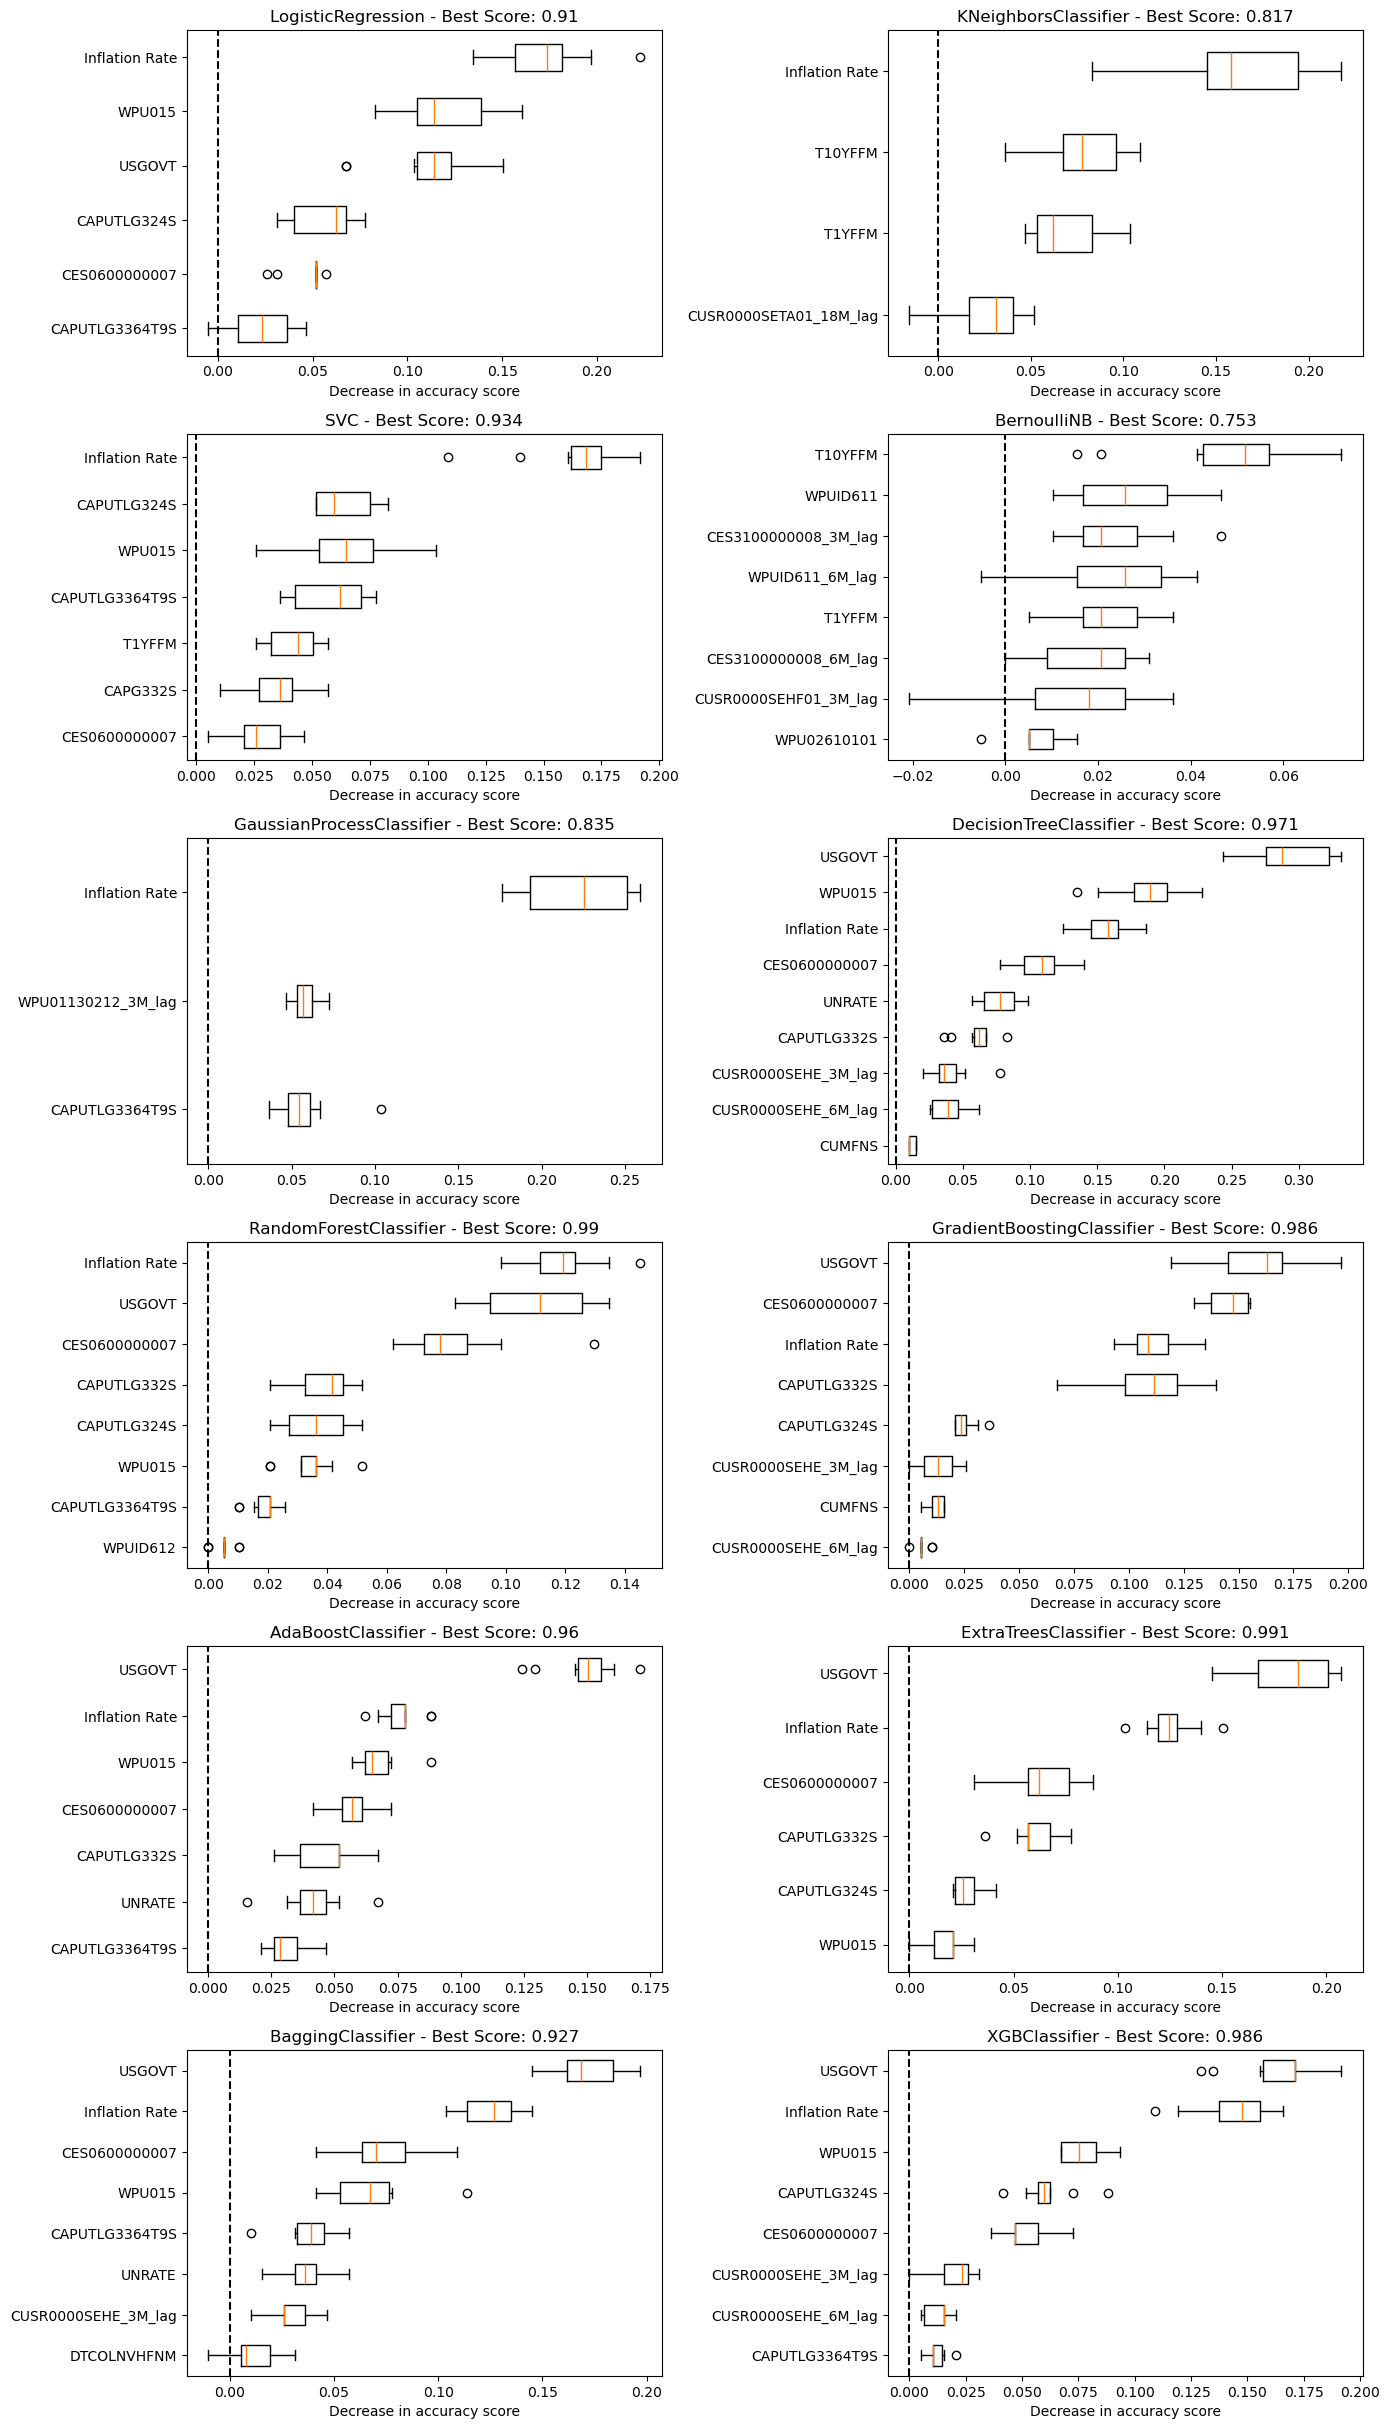

Results exported to permutation_importance_bear_std.csv
Execution time of optimize_and_evaluate function: 162.38 seconds
Optimization and evaluation complete.


In [91]:
results_df = optimize_and_evaluate(baseline_models, target_types=['bear'], split_types=['std'], visualize=True)

print("Optimization and evaluation complete.")


In [92]:
results_df.head()

,model,best_score,best_features
0,LogisticRegression,0.910053,"[USGOVT, CES0600000007, CAPUTLG3364T9S, CAPUTL..."
1,KNeighborsClassifier,0.817269,"[T10YFFM, T1YFFM, Inflation Rate, CUSR0000SETA..."
2,SVC,0.934002,"[T1YFFM, CES0600000007, CAPUTLG3364T9S, CAPUTL..."
4,BernoulliNB,0.752702,"[T10YFFM, T1YFFM, WPUID611, WPU02610101, CES31..."
5,GaussianProcessClassifier,0.835481,"[CAPUTLG3364T9S, Inflation Rate, WPU01130212_3..."


In [70]:
def load_and_parse_results(filename='feature_selection/permutation_importance_bear_std.csv'):
    results_df = pd.read_csv(filename, sep='\t')
    # drop na
    results_df = results_df.dropna()
    # Parse the 'best_features' column from string representation of a list to an actual list
    results_df['best_features'] = results_df['best_features'].apply(ast.literal_eval)
    return results_df

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """
    Helper function to train and evaluate a model on the test set. 
    Returns a dictionary of evaluation metrics.
    """
    model = clone(model)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    Y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "recall": recall_score(y_test, Y_pred, average='macro'),
        "roc_auc": roc_auc_score(y_test, Y_pred_proba) if hasattr(model, "predict_proba") else None,
        "accuracy": accuracy_score(y_test, Y_pred),
        "precision": precision_score(y_test, Y_pred, average='macro'),
        "f1": f1_score(y_test, Y_pred, average='macro'),
    }

    results = {metric_name: round(metric_func, 4) for metric_name, metric_func in metrics.items()}
    return results

def get_evaluation(models, X_train, X_test, y_train, y_test, results_df):
    """
    Evaluate the models using the best features found from the feature selection process.
    Returns a DataFrame with the evaluation results.
    """
    evaluation_results = []

    for model in models:
        model_name = model.__class__.__name__
        # Ensure best_features is a flat list of feature names
        best_features_series = results_df.loc[results_df['model'] == model_name, 'best_features']
        if not best_features_series.empty:
            best_features = best_features_series.iloc[0]  # Access the first item if Series is not empty

            # Subset the datasets with the best features
            X_train_best = X_train[best_features].copy()
            X_test_best = X_test[best_features].copy()

            # Check if model needs scaling
            if model_name in model_needs_scaling:
                X_train_best, X_test_best = scale_data(X_train_best, X_test_best)

            # Evaluate the model using the best features
            metrics = train_and_evaluate(model, X_train_best, y_train, X_test_best, y_test)
            evaluation_results.append([model_name] + list(metrics.values()))
        else:
            print(f"No best features found for {model_name}, skipping.")

    # Convert the evaluation results into a DataFrame
    if evaluation_results:
        # Directly use the metric names from the dictionary used in `train_and_evaluate`
        metric_names = ['model'] + list(metrics.keys())  # Use metrics from the last iteration
        evaluation_df = pd.DataFrame(evaluation_results, columns=metric_names)
    else:
        evaluation_df = pd.DataFrame(columns=['model'] + list(metrics.keys()))

    # set the model name as the index
    evaluation_df = evaluation_df.set_index('model')
    evaluation_df.index.name = None

    # sort by recall
    evaluation_df = evaluation_df.sort_values(by='recall', ascending=False)
    return evaluation_df

X_train, y_train, X_test, y_test = load_data()
results_df = load_and_parse_results()
eval_df = get_evaluation(baseline_models, X_train, X_test, y_train, y_test, results_df)
print(eval_df)

# export to csv
eval_df.to_csv("feature_selection/feature_selection_evaluation.csv")

Loaded X_train_bear_std.csv, y_train_bear_std.csv, X_test_bear_std.csv, and y_test_bear_std.csv.

No best features found for GaussianNB, skipping.
                            recall  roc_auc  accuracy  precision      f1
RandomForestClassifier      0.9846   0.9976    0.9896     0.9923  0.9883
ExtraTreesClassifier        0.9846   0.9977    0.9896     0.9923  0.9883
XGBClassifier               0.9807   0.9978    0.9845     0.9844  0.9825
GradientBoostingClassifier  0.9769   0.9962    0.9845     0.9885  0.9824
DecisionTreeClassifier      0.9691   0.9691    0.9741     0.9727  0.9709
AdaBoostClassifier          0.9537   0.9582    0.9637     0.9648  0.9589
BaggingClassifier           0.9111   0.9683    0.9223     0.9143  0.9127
SVC                         0.9075   0.9837    0.9275     0.9288  0.9168
LogisticRegression          0.8841   0.9601    0.9016     0.8935  0.8885
GaussianProcessClassifier   0.8108   0.8867    0.8394     0.8240  0.8166
KNeighborsClassifier        0.7724   0.9008    0.8